# Evaluate AI Generated Content

In [1]:
# import statements

import csv
import spacy
from transformers import BertTokenizer, BertForNextSentencePrediction
import torch
from collections import defaultdict
import matplotlib.pyplot as plt
import random

/Users/adhit/opt/anaconda3/envs/truman-env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Read Content

### AI-Generated Content

In [2]:
# notifications (reply)

ai_notifications_replies = []
with open('ai_input/notifications (reply).csv', 'r', newline='') as file:
    reader = csv.reader(file, delimiter=",")
    header = next(reader)
    for line in reader:
        ai_notifications_replies.append(line[header.index("body")].replace("\"", ""))

In [3]:
# replies

ai_replies = []
ai_replies_dict = defaultdict(list)
with open('ai_input/replies.csv', 'r', newline='') as file:
    reader = csv.reader(file, delimiter=",")
    header = next(reader)
    for line in reader:
        id = line[header.index("postID")]
        reply = line[header.index("body")]
        ai_replies_dict[id].append(reply)
        ai_replies.append(reply.replace("\"", ""))

In [4]:
# post captions

ai_post_captions = []
ai_posts_dict = {}
with open('ai_input/posts.csv', 'r', newline='') as file:
    reader = csv.reader(file, delimiter=",")
    header = next(reader)
    for line in reader:
        id = line[header.index("id")]
        caption = line[header.index("body")]
        ai_posts_dict[id] = caption
        ai_post_captions.append(caption.replace("\"", ""))

In [5]:
# actor bios

ai_actor_bios = []
with open('ai_input/actors.csv', 'r', newline='') as file:
    reader = csv.reader(file, delimiter=",")
    header = next(reader)
    for line in reader:
        ai_actor_bios.append(line[header.index("bio")].replace("\"", ""))

### Example Content

In [6]:
# notifications (reply)

notifications_replies = []
with open('input/notifications (reply).csv', 'r', newline='') as file:
    reader = csv.reader(file, delimiter=",")
    header = next(reader)
    for line in reader:
        notifications_replies.append(line[header.index("body")].replace("\"", ""))

In [7]:
# replies

replies = []
with open('input/replies.csv', 'r', newline='') as file:
    reader = csv.reader(file, delimiter=",")
    header = next(reader)
    for line in reader:
        replies.append(line[header.index("body")].replace("\"", ""))

In [8]:
# post captions

post_captions = []
with open('input/posts.csv', 'r', newline='') as file:
    reader = csv.reader(file, delimiter=",")
    header = next(reader)
    for line in reader:
        post_captions.append(line[header.index("body")].replace("\"", ""))

In [9]:
# actor bios

actor_bios = []
with open('input/actors.csv', 'r', newline='') as file:
    reader = csv.reader(file, delimiter=",")
    header = next(reader)
    for line in reader:
        actor_bios.append(line[header.index("bio")].replace("\"", ""))

## Evaluate Content

### Helper Methods

In [10]:
# similarity

nlp = spacy.load("en_core_web_lg")

def similarity_score(sentence1, sentence2):
    doc1 = nlp(sentence1)
    doc2 = nlp(sentence2)
    return doc1.similarity(doc2)

In [11]:
# coherence

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForNextSentencePrediction.from_pretrained('bert-base-uncased')

def coherence_score(caption, reply):
    sentence1 = "{}".format(caption)
    sentence2 = "{}".format(reply)
    tokenized = tokenizer(sentence1, sentence2, return_tensors='pt')
    labels = torch.LongTensor([0])
    predict = model(**tokenized, labels=labels)
    probs = torch.nn.functional.softmax(predict.logits[0], dim=0)
    return probs[0].item()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForNextSentencePrediction: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Coherence between post and comments over time

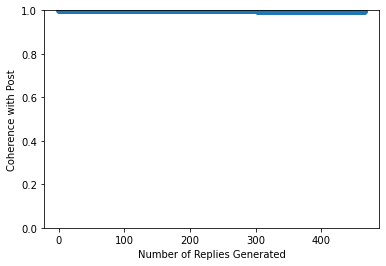

In [12]:
# ai_posts_dict[post_id] = post_caption
# ai_replies_dict[post_id] = [replies]

points = []
num_replies = 0
sum_scores = 0
num_scores = 0
for id in ai_posts_dict.keys():
    caption = ai_posts_dict[id]
    replies = ai_replies_dict[id]
    for reply in replies:
        num_replies += 1
        sum_scores += coherence_score(caption, reply)
        num_scores += 1
        points.append((num_replies, sum_scores/num_scores))

x = [i[0] for i in points]
y = [i[1] for i in points]
plt.scatter(x, y)
plt.ylim(0,1)
plt.xlabel("Number of Replies Generated")
plt.ylabel("Coherence with Post")
plt.show()

### Comment creativity (1-similarity) over time

#### including comparison with comments under same post

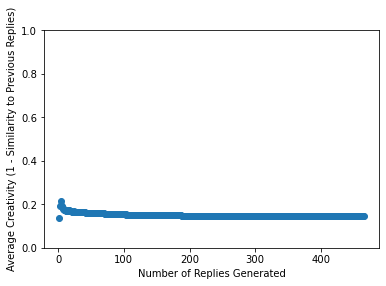

In [13]:
points = []
previous_replies = []
sum_scores = 0
num_scores = 0
k = 25 # for subsampling previous replies for similarity comparison
for id in ai_posts_dict.keys():
    replies = ai_replies_dict[id]
    for curr_reply in replies:
        scores = []
        for prev_reply in random.sample(previous_replies, min(len(previous_replies), k)):
            scores.append(1 - similarity_score(curr_reply, prev_reply))
        try:
            sum_scores += sum(scores)/len(scores)
            num_scores += 1
            previous_replies.append(curr_reply)
            points.append((len(previous_replies), sum_scores/num_scores))
        except:
            previous_replies.append(curr_reply)

x = [i[0] for i in points]
y = [i[1] for i in points]
plt.scatter(x, y)
plt.ylim(0,1)
plt.xlabel("Number of Replies Generated")
plt.ylabel("Average Creativity (1 - Similarity to Previous Replies)")
plt.show()

#### excluding comparison with comments under same post

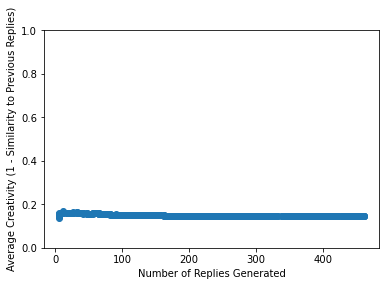

In [14]:
points = []
previous_replies = []
sum_scores = 0
num_scores = 0
k = 25 # for subsampling previous replies for similarity comparison
for id in ai_posts_dict.keys():
    replies = ai_replies_dict[id]
    for curr_reply in replies:
        scores = []
        for prev_reply in random.sample(previous_replies, min(len(previous_replies), k)):
            scores.append(1 - similarity_score(curr_reply, prev_reply))
        try:
            sum_scores += sum(scores)/len(scores)
            num_scores += 1
            points.append((len(previous_replies), sum_scores/num_scores))
        except:
            pass
    previous_replies += replies

x = [i[0] for i in points]
y = [i[1] for i in points]
plt.scatter(x, y)
plt.ylim(0,1)
plt.xlabel("Number of Replies Generated")
plt.ylabel("Average Creativity (1 - Similarity to Previous Replies)")
plt.show()

### Similarity with actor bio examples 

<ipython-input-10-6ddf7aaa9631>:8: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  return doc1.similarity(doc2)


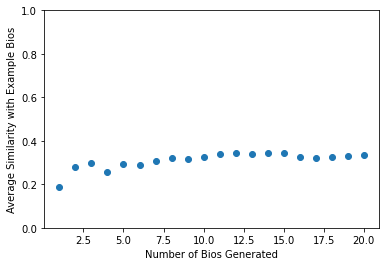

In [15]:
examples = []
examples = actor_bios

points = []
sum_scores = 0
num_scores = 0
for bio in ai_actor_bios:
    scores = []
    for example in examples:
        scores.append(similarity_score(bio, example))
    sum_scores += sum(scores)/len(scores)
    num_scores += 1
    points.append((num_scores, sum_scores/num_scores))

x = [i[0] for i in points]
y = [i[1] for i in points]
plt.scatter(x, y)
plt.ylim(0,1)
plt.xlabel("Number of Bios Generated")
plt.ylabel("Average Similarity with Example Bios")
plt.show()